# Stars or Storyline: How Actor Fame and Sentiment Trajectories Shape a Movie's Critical Success

# 0. Introduction

In the world of cinema, the question of what makes a movie successful remains complex and multi-faceted. Is it the star power of its cast, or does a captivating storyline hold more sway over an audience’s perception? Our project seeks to dissect these influences to understand what contributes more to a movie's critical success. We believe that the key elements lie in both the fame of the actors involved and the emotional journey crafted within the plot. What factors influence the most to predict the success of a movie?

Our approach explores two primary factors: actor fame and the sentiment trajectory of the movie plot. Using sentiment analysis on plot summaries, we examine the emotional arc of each story, uncovering patterns in tone and intensity. In parallel, we perform social network analysis to evaluate the influence of an actor’s connections and prominence within the industry.

In this results notebook, we showcase the different methods considered, the results obtained, the reasoning behind each decision, and additional reflections. Each section highlights our approach, the key insights derived, and the practical choices made along the way. This notebook consolidates our main findings, while the core logic is implemented in external scripts that we call from here.

Our ultimate goal is to provide a nuanced perspective on the elements that contribute to a movie’s success, examining whether a compelling emotional arc or the presence of influential actors holds more weight in capturing an audience’s approval.



# 1. Data Cleaning and Preprocessing

### 1.1 Clean the Datasets

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# Import the cleaning functions from cleaning.py located in 'tests/Data Cleaning and Preprocessing'
from tests.Data_Cleaning_and_Preprocessing.cleaning import (
    clean_tvtropes_clusters,
    clean_name_clusters,
    clean_character_metadata,
    clean_plot_summaries,
    clean_movie_metadata
)

# Define the data directory
data_directory = os.path.join(os.getcwd(), 'src', 'data')

# Call each cleaning function and save the cleaned data as DataFrames
tvtropes_df = clean_tvtropes_clusters(data_directory)
name_clusters_df = clean_name_clusters(data_directory)
character_metadata_df = clean_character_metadata(data_directory)
plot_summaries_df = clean_plot_summaries(data_directory)
movie_metadata_df = clean_movie_metadata(data_directory)

# Display the first few rows of each DataFrame to verify cleaning
print("TV Tropes Clusters:")
display(tvtropes_df.head())

print("Name Clusters:")
display(name_clusters_df.head())

print("Character Metadata:")
display(character_metadata_df.head())

print("Plot Summaries:")
display(plot_summaries_df.head())

print("Movie Metadata:")
display(movie_metadata_df.head())


# Save the cleaned DataFrames to CSV files in the main 'data' directory with error handling for encoding
tvtropes_df.to_csv(os.path.join('data', 'tvtropes_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
name_clusters_df.to_csv(os.path.join('data', 'name_clusters_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
character_metadata_df.to_csv(os.path.join('data', 'character_metadata_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
plot_summaries_df.to_csv(os.path.join('data', 'plot_summaries_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
movie_metadata_df.to_csv(os.path.join('data', 'movie_metadata_cleaned.csv'), index=False, encoding='utf-8', errors='replace')



#### Explanation of Data Cleaning Functions in `cleaning.py`

##### 1. `clean_tvtropes_clusters`
- **Objective**: Clean the `tvtropes.clusters.txt` file.
- **Process**:
  - Parses the `details` field, which contains JSON-like data, to extract key fields such as `character`, `movie`, `movie_id`, and `actor`.
  - Converts this data into a cleaner format by organizing the extracted values into individual columns, making the dataset easier to work with.

##### 2. `clean_name_clusters`
- **Objective**: Clean the `name.clusters.txt` file.
- **Process**:
  - Loads the data and assigns column names (`name`, `cluster_id`) for clarity.
  - Checks for and removes any missing or redundant entries to ensure consistency.

##### 3. `clean_character_metadata`
- **Objective**: Clean the `character.metadata.tsv` file.
- **Process**:
  - Fixes misalignments where rows contain extra `Freebase` character columns, ensuring all rows have consistent structure.
  - Replaces `Unknown` with `NaN` for missing data, and assigns appropriate data types to columns like `actor_height` and `actor_age`.
  - Ensures realistic values in the `actor_age` column by converting negative values to positive and setting a maximum age limit.

##### 4. `clean_plot_summaries`
- **Objective**: Clean the `plot_summaries.txt` file.
- **Process**:
  - Loads the plot summaries dataset, verifies unique `movie_id`s, and checks for duplicates.
  - Prepares the plot summaries for further analysis by ensuring each summary is correctly linked to its respective movie ID.

##### 5. `clean_movie_metadata`
- **Objective**: Clean the `movie.metadata.tsv` file.
- **Process**:
  - Parses fields like `countries`, `genres`, and `languages` to extract human-readable values from dictionary-like entries.
  - Handles missing values for key columns such as `release_date`, `revenue`, and `runtime`.
  - Generates cleaned versions of `languages`, `countries`, and `genres` columns, creating a standardized format.


### 1.2 Adding Ratings

### 1.3 Adding missing Data


### 1.4 Master Dataset

# 2. Metric Selection and Preliminary Analysis

### 2.1 Definition of Sucess

To conduct any meaningful analysis of success, it’s crucial to first define what “success” actually means in the given context. Success is a multifaceted concept that can vary widely depending on goals, stakeholders, and industry standards. Without a clear definition, it’s challenging to identify the factors that contribute to success or measure their impact accurately.

Defining success requires selecting parameters that align with the unique objectives and context of the analysis. In the film industry, for instance, success could be measured by revenue, which speaks to a movie's commercial appeal, or by critical reviews, which reflect its artistic and cultural impact. However, factors like the size of the target audience and the specific market or country also shape these definitions. A blockbuster may achieve global success through widespread appeal and high box office revenue, whereas an independent film might be considered successful if it performs well locally, resonating strongly with a niche audience or in a particular country.

### 2.2 Preliminary Analysis

#### General

Having a comprehensive overview of our datasets is crucial to understanding their scope and dimensions. Visualizing the data can often spark new ideas, raise pertinent questions, and guide the direction of our analysis. By examining the general characteristics and distributions within our datasets, we can identify patterns, anomalies, and potential areas of interest that warrant further investigation. This initial exploration sets the foundation for more detailed and targeted analyses in subsequent sections.

In [ ]:
# Data preprocessing and analysis
movie_metadata_df['year'] = pd.to_datetime(movie_metadata_df['release_date'], errors='coerce').dt.year
df_cleaned = movie_metadata_df.dropna(subset=['year', 'revenue'])
df_cleaned['revenue'] = pd.to_numeric(df_cleaned['revenue'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['revenue'])
revenue_stats = df_cleaned.groupby('year')['revenue'].agg(['mean', 'std', 'median', 'min', 'max'])

# Proportion of movies with box office revenue available
total_movies = movie_metadata_df.shape[0]
movies_with_revenue = movie_metadata_df['revenue'].notna().sum()
proportion_with_revenue = movies_with_revenue / total_movies
background_color = '#1e1e1e'

C:\Users\Pierre\AppData\Local\Temp\ipykernel_16704\2921704650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['revenue'] = pd.to_numeric(df_cleaned['revenue'], errors='coerce')


### Ratings

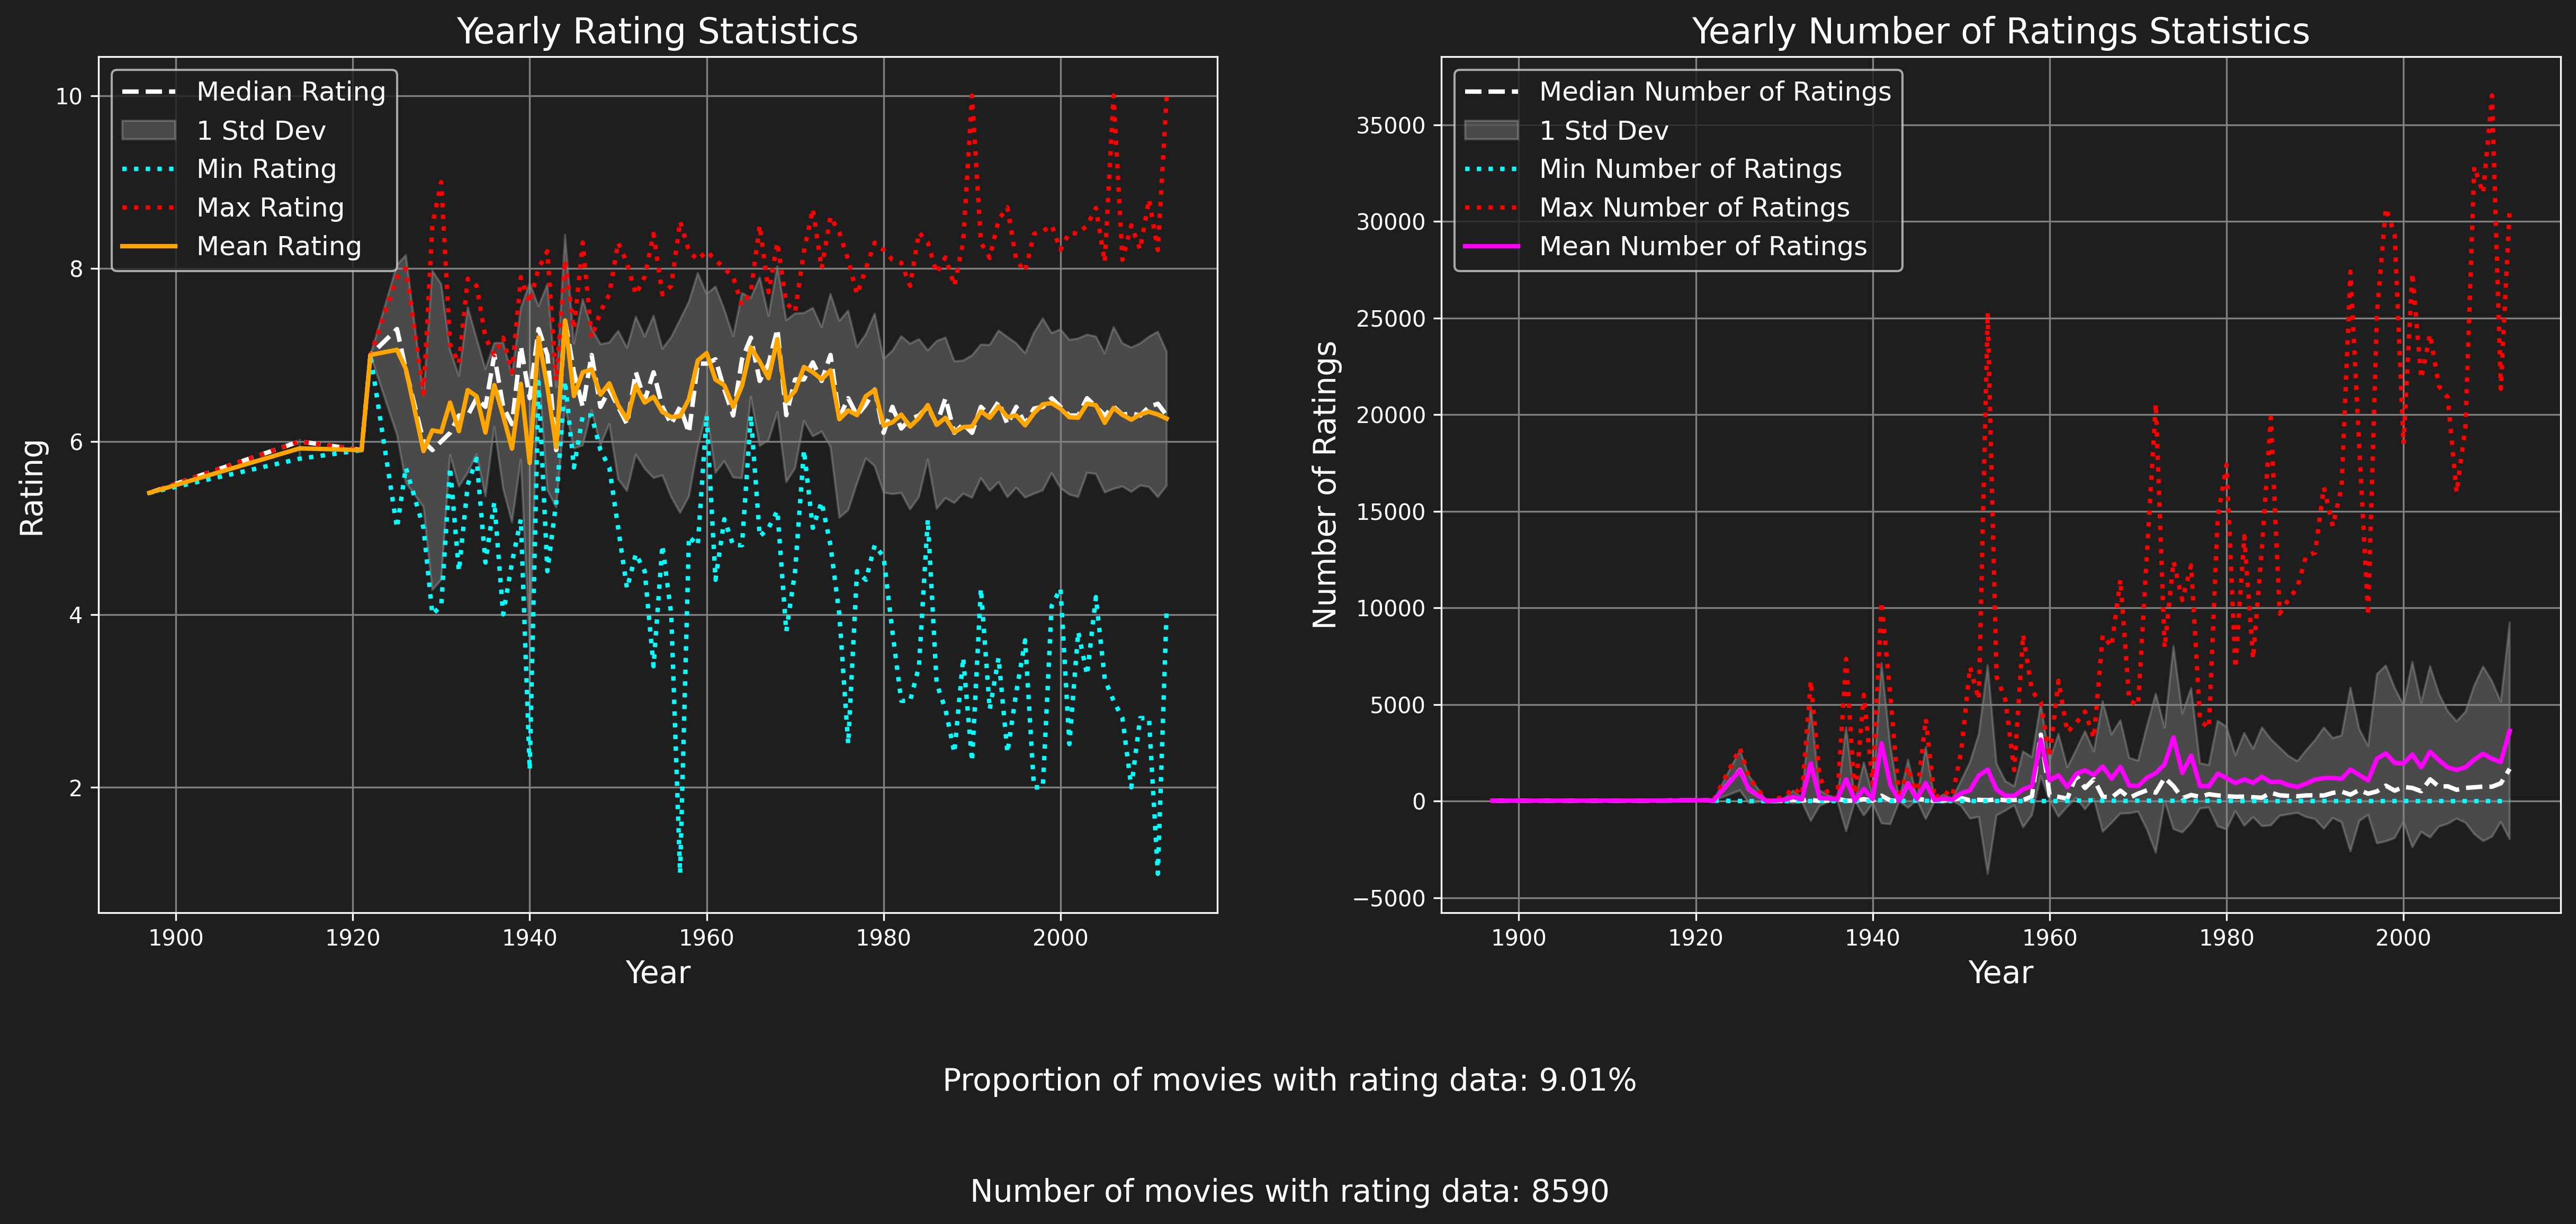

In [ ]:
# Ensure the release_date column is in datetime format
df_cleaned['release_date'] = pd.to_datetime(df_cleaned['release_date'], errors='coerce')

# Filter out movies with 0 ratings
df_filtered_ratings = df_cleaned[df_cleaned['rating'] > 0]

# Group by year and calculate the statistics for ratings
rating_stats = df_filtered_ratings.groupby(df_filtered_ratings['release_date'].dt.year)['rating'].agg(['mean', 'median', 'std', 'min', 'max'])

# Filter out movies with 0 vote_count
df_filtered_votes = df_cleaned[df_cleaned['vote_count'] > 0]

# Group by year and calculate the statistics for vote_count
vote_count_stats = df_filtered_votes.groupby(df_filtered_votes['release_date'].dt.year)['vote_count'].agg(['mean', 'median', 'std', 'min', 'max'])

# Set the dark mode style
plt.style.use('dark_background')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), dpi=300)
fig.patch.set_facecolor(background_color)
for ax in axes:
    ax.set_facecolor(background_color)

# Plot the rating statistics
axes[0].plot(rating_stats.index, rating_stats['median'], label='Median Rating', color='white', linewidth=2, linestyle='--')
axes[0].fill_between(rating_stats.index, rating_stats['mean'] - rating_stats['std'], rating_stats['mean'] + rating_stats['std'], color='white', alpha=0.2, label='1 Std Dev')
axes[0].plot(rating_stats.index, rating_stats['min'], label='Min Rating', linestyle=':', color='cyan', linewidth=2)
axes[0].plot(rating_stats.index, rating_stats['max'], label='Max Rating', linestyle=':', color='red', linewidth=2)
axes[0].plot(rating_stats.index, rating_stats['mean'], label='Mean Rating', color='orange', linewidth=2)
axes[0].set_title('Yearly Rating Statistics', fontsize=16, color='white')
axes[0].set_xlabel('Year', fontsize=14, color='white')
axes[0].set_ylabel('Rating', fontsize=14, color='white')
axes[0].grid(True, color='gray')
legend = axes[0].legend(fontsize=12, loc='upper left')
legend.get_frame().set_facecolor(background_color)

# Plot the vote count statistics
axes[1].plot(vote_count_stats.index, vote_count_stats['median'], label='Median Number of Ratings', color='white', linewidth=2, linestyle='--')
axes[1].fill_between(vote_count_stats.index, vote_count_stats['mean'] - vote_count_stats['std'], vote_count_stats['mean'] + vote_count_stats['std'], color='white', alpha=0.2, label='1 Std Dev')
axes[1].plot(vote_count_stats.index, vote_count_stats['min'], label='Min Number of Ratings', linestyle=':', color='cyan', linewidth=2)
axes[1].plot(vote_count_stats.index, vote_count_stats['max'], label='Max Number of Ratings', linestyle=':', color='red', linewidth=2)
axes[1].plot(vote_count_stats.index, vote_count_stats['mean'], label='Mean Number of Ratings', color='magenta', linewidth=2)
axes[1].set_title('Yearly Number of Ratings Statistics', fontsize=16, color='white')
axes[1].set_xlabel('Year', fontsize=14, color='white')
axes[1].set_ylabel('Number of Ratings', fontsize=14, color='white')
axes[1].grid(True, color='gray')
legend = axes[1].legend(fontsize=12, loc='upper left')
legend.get_frame().set_facecolor(background_color)

# Set tick parameters
for ax in axes:
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

# Add the number of movies plotted at the bottom of the figure
num_movies_plotted = len(df_cleaned)
proportion_with_rating = num_movies_plotted / total_movies
plt.figtext(0.5, -0.05, f"Proportion of movies with rating data: {proportion_with_rating:.2%}", ha='center', fontsize=14, color='white')
plt.figtext(0.5, -0.15, f"Number of movies with rating data: {num_movies_plotted}", ha='center', fontsize=14, color='white')

plt.show()


### Success
Success can be defined in many ways, taking into account many parameters. However, we think that with limited knowledge, a simple definition can be more robust.
Therfore we define the success of a movie based on its rating, and the intrest it raised. We quantify it the following way: Success = rating*log(number of ratings)
The logarithm enables to keep success to scale as it is a number that can vary drastically.

In [ ]:
# Define the success metric
def calculate_success(row):
    if pd.isna(row['rating']) or pd.isna(row['vote_count']) or row['vote_count'] == 0:
        return 0
    return row['rating'] * np.log(row['vote_count'])


In [ ]:
# Calculate the mean and median success for each year
df_cleaned['success'] = df_cleaned.apply(calculate_success, axis=1)

# Filter out rows with NaN values in 'revenue' or 'success' and rows with 0 votes
df_filtered = df_cleaned.dropna(subset=['revenue', 'success'])
success_stats = df_filtered[df_filtered['vote_count'] > 0]

success_stats = df_cleaned.groupby('year')['success'].agg(['mean', 'median'])

# Set the dark mode style
plt.style.use('dark_background')

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
fig.patch.set_facecolor(background_color)  # Set the figure background color
ax.set_facecolor(background_color)  # Set the axes background color

# Plot the success statistics
ax.plot(success_stats.index, success_stats['median'], label='Median Success', color='white', linewidth=2, linestyle='--')
ax.plot(success_stats.index, success_stats['mean'], label='Mean Success', color='orange', linewidth=2)

# Plot settings
ax.set_title('Yearly Success Statistics', fontsize=16, color='white')
ax.set_xlabel('Year', fontsize=14, color='white')
ax.set_ylabel('Success', fontsize=14, color='white')
ax.grid(True, color='gray')
legend = ax.legend(fontsize=12, loc='upper left')
legend.get_frame().set_facecolor(background_color)

# Set tick parameters
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()

NameError: name 'np' is not defined

### Revenue

The first factor to explore is revenue, as it is often a primary indicator of a movie’s commercial success.

By plotting the sum of movie revenues over time, we can get a sense of growth trends, but this analysis is biased due to a higher number of recent movies in the database. It’s unclear whether fewer movies were made in earlier years or if the dataset simply contains more recent entries. Additionally, this analysis doesn’t account for inflation, which affects the comparability of revenue figures across different time periods.

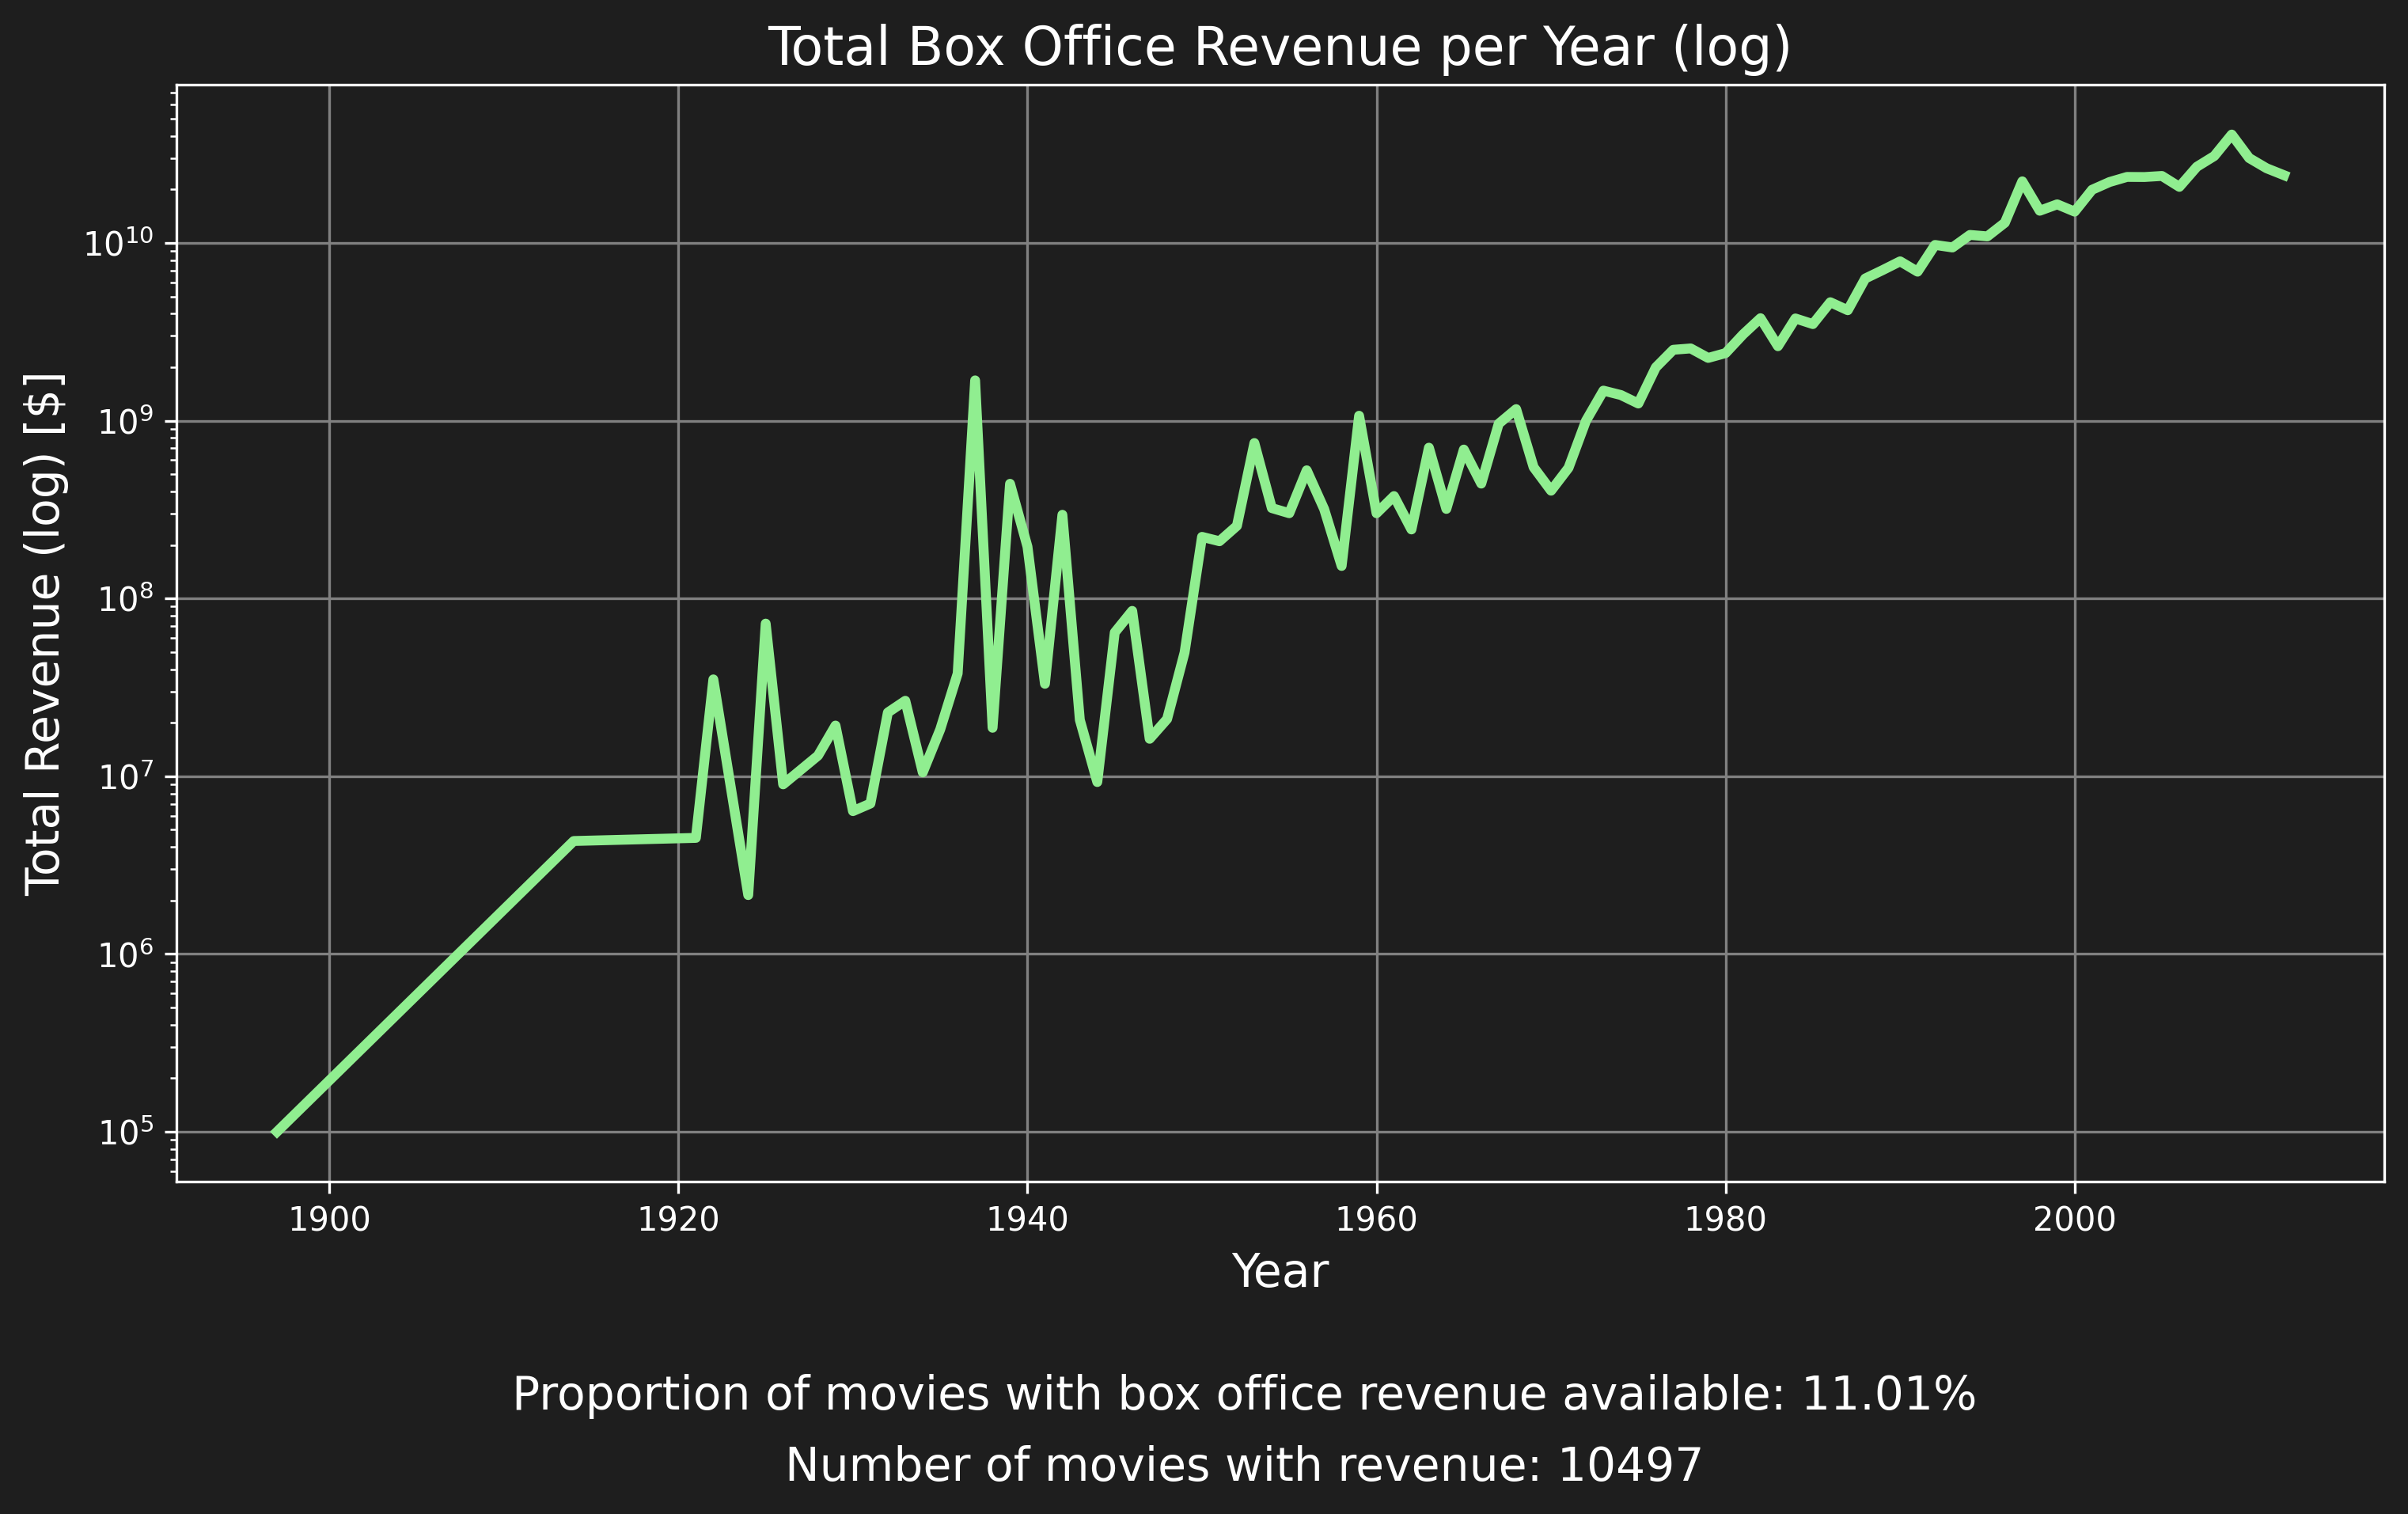

In [ ]:
# Set the dark mode style
plt.style.use('dark_background')


# Plot: Total Box Office Revenue per Year
total_revenue_per_year = df_cleaned.groupby('year')['revenue'].sum()

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
fig.patch.set_facecolor(background_color)  # Set the figure background color
ax.set_facecolor(background_color)  # Set the axes background color

ax.plot(total_revenue_per_year.index, total_revenue_per_year.values, color='lightgreen', linewidth=3)
ax.set_title('Total Box Office Revenue per Year (log)', fontsize=16, color='white')
ax.set_xlabel('Year', fontsize=14, color='white')
ax.set_ylabel('Total Revenue (log) [$]', fontsize=14, color='white')
ax.set_yscale('log')  # Set y-axis to log scale
ax.grid(True, color='gray')

plt.figtext(0.5, -0.05, f"Proportion of movies with box office revenue available: {proportion_with_revenue:.2%}", ha='center', fontsize=14, color='white')
plt.figtext(0.5, -0.1, f"Number of movies with revenue: {movies_with_revenue}", ha='center', fontsize=14, color='white')

plt.show()


By analyzing the mean revenue over time, we observe spikes in certain decades, notably the 1960s, 1970s, 2000s, and around 2012, despite an overall upward trend. When using the median instead of the mean, these spikes appear even more pronounced, indicating periods of exceptionally high revenue for certain movies. Adjusting for inflation would likely amplify these spikes further, suggesting that some decades represent peaks of heightened interest or popularity in the film industry.

The variance in movie revenues has not remained constant over time, indicating a broader range of outcomes in recent years. This suggests an increasing variety of both high-grossing hits and low-performing flops, reflecting a more polarized landscape in the film industry. Over time, movies have become more variable in their success, likely due to factors like larger budgets for blockbusters, a growing number of independent films, and shifting audience preferences.

Revenue data shows distinct spikes of interest in movies across different decades, indicating varying peaks of popularity over time. However, relying on revenue alone to measure a movie’s success has limitations. Local successes in smaller countries with high popularity but lower revenue can be overlooked, and differences in purchasing power between rich and poor countries create disparities in revenue data. Additionally, without adjusting for inflation, revenue figures can misrepresent a movie’s true economic impact over time. Therefore, revenue alone is not a reliable indicator to fully explain a movie’s success. Other metrics should be considered for a more comprehensive understanding.

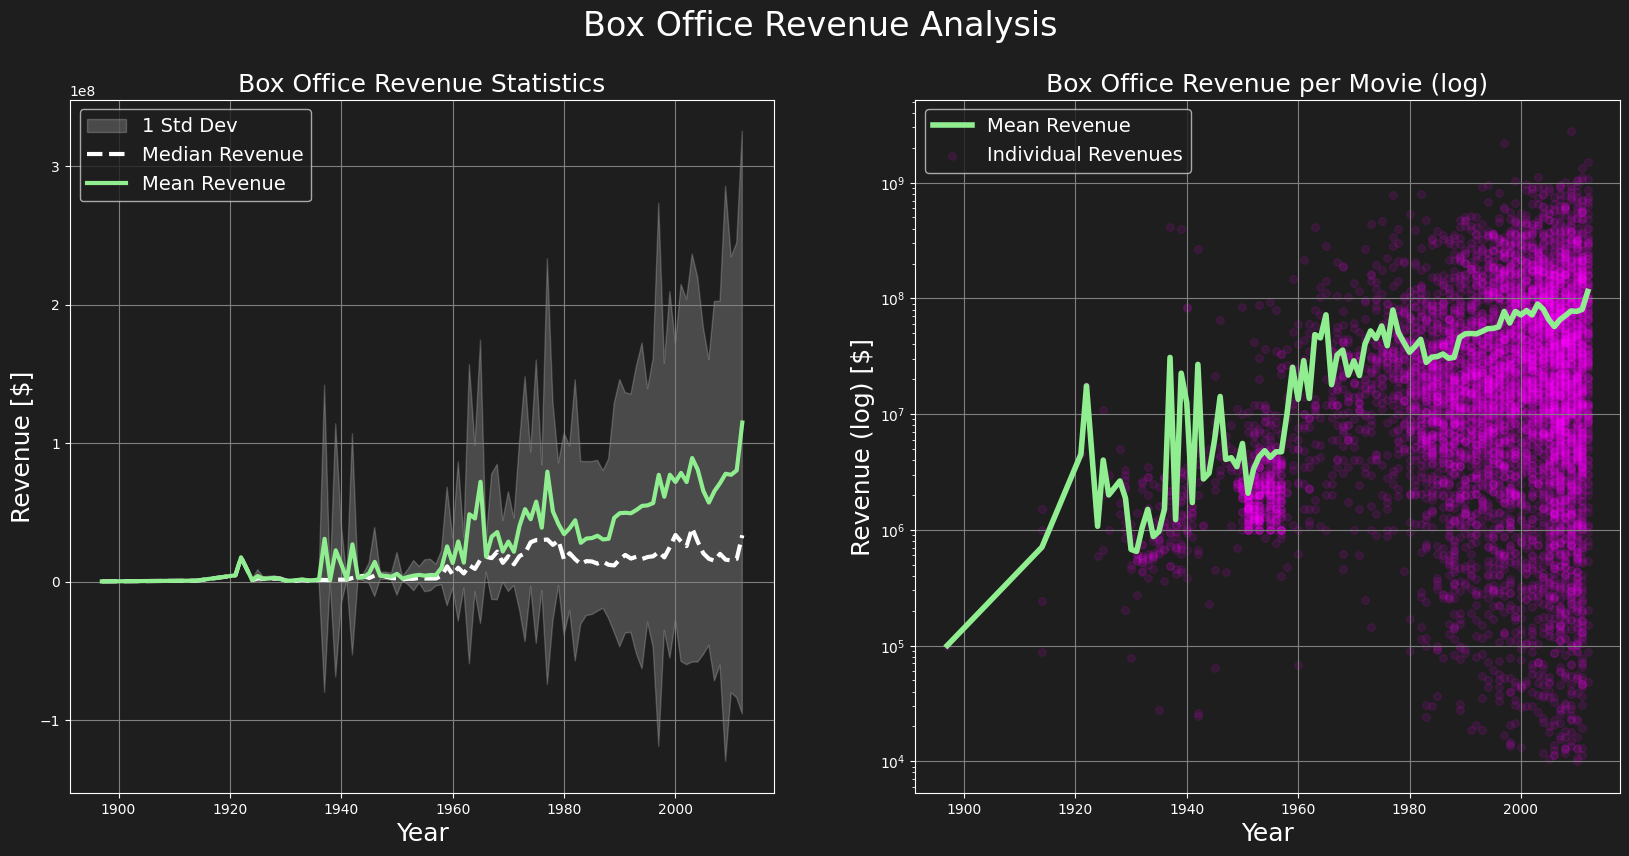

In [ ]:


# Set the dark mode style
#plt.style.use('dark_background')

# Define the background color similar to VSCode's dark theme
background_color = '#1e1e1e'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
fig.patch.set_facecolor(background_color)
for ax in axes:
    ax.set_facecolor(background_color)

# Main title
fig.suptitle('Box Office Revenue Analysis', fontsize=24, color='white')

# Plot 1
axes[0].fill_between(revenue_stats.index, revenue_stats['mean'] - revenue_stats['std'],
                     revenue_stats['mean'] + revenue_stats['std'], color='white', alpha=0.2, label='1 Std Dev')
axes[0].plot(revenue_stats.index, revenue_stats['median'], label='Median Revenue', linestyle='--', color='white', linewidth=3)
axes[0].plot(revenue_stats.index, revenue_stats['mean'], label='Mean Revenue', color='lightgreen', linewidth=3)
axes[0].set_title('Box Office Revenue Statistics', fontsize=18, color='white')
axes[0].set_xlabel('Year', fontsize=18, color='white')
axes[0].set_ylabel('Revenue [$]', fontsize=18, color='white')
axes[0].legend(fontsize=14)
axes[0].grid(True, color='gray')

# Plot 2
axes[1].plot(revenue_stats.index, revenue_stats['mean'], label='Mean Revenue', color='lightgreen', linewidth=4)
axes[1].scatter(df_cleaned['year'], df_cleaned['revenue'], color='magenta', alpha=0.1, label='Individual Revenues', s=30)
axes[1].set_title('Box Office Revenue per Movie (log)', fontsize=18, color='white')
axes[1].set_xlabel('Year', fontsize=18, color='white')
axes[1].set_ylabel('Revenue (log) [$]', fontsize=18, color='white')
axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].legend(fontsize=14)
axes[1].grid(True, color='gray')

# Set tick parameters
for ax in axes:
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

plt.show()

#### Ratings

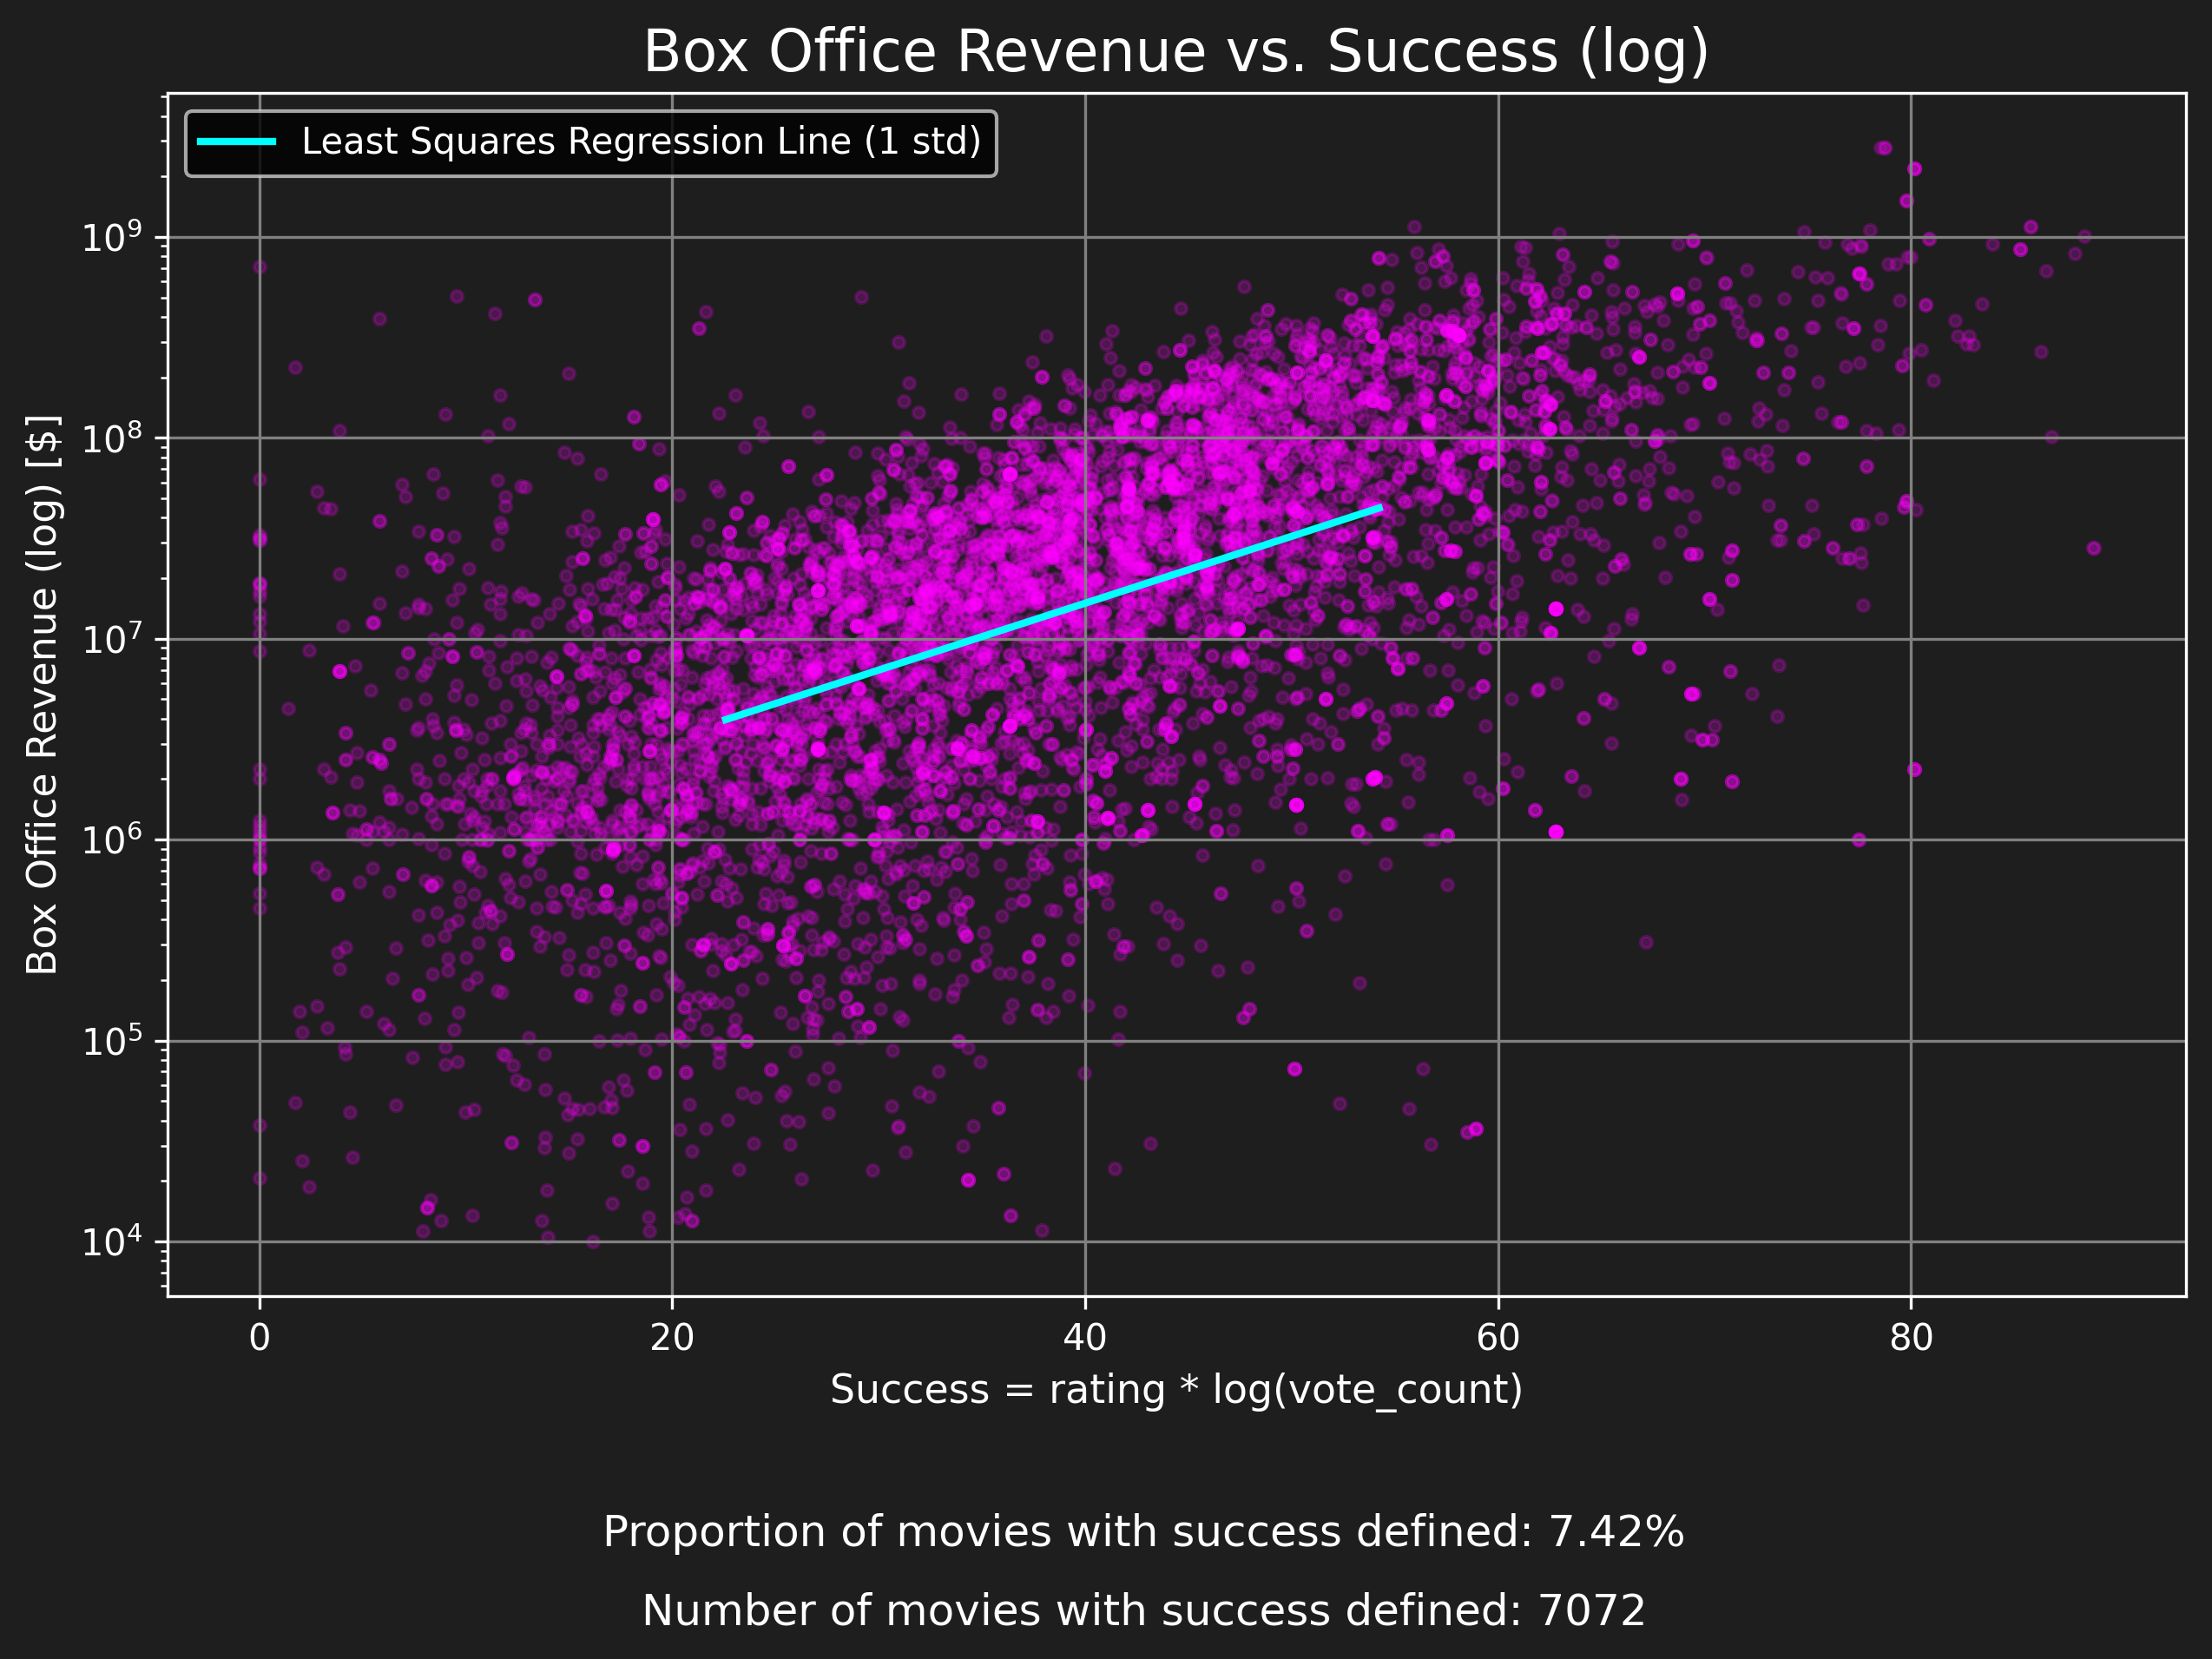

In [ ]:
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


# Apply the success metric calculation to the dataframe
df_cleaned['success'] = df_cleaned.apply(calculate_success, axis=1)

# Filter out rows with NaN values in 'revenue' or 'success' and rows with 0 votes
df_filtered = df_cleaned.dropna(subset=['revenue', 'success'])
df_filtered = df_filtered[df_filtered['vote_count'] > 0]

# Set the dark mode style
plt.style.use('dark_background')

# Plot the box office revenue over success
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
fig.patch.set_facecolor(background_color)  # Set the figure background color
ax.set_facecolor(background_color)  # Set the axes background color

# Scatter plot
ax.scatter(df_filtered['success'], df_filtered['revenue'], alpha=0.2, color='magenta', s=10)

# Fit a least squares regression line to the log-transformed revenue
log_revenue = np.log(df_filtered['revenue'])
coefficients = np.polyfit(df_filtered['success'], log_revenue, 1)
poly = np.poly1d(coefficients)

# Calculate mean and standard deviation of success
mean_success = df_filtered['success'].mean()
std_success = df_filtered['success'].std()

# Define x values for the regression line within 1 standard deviation
x = np.linspace(mean_success - std_success, mean_success + std_success, 100)
y = np.exp(poly(x))

# Plot the regression line
ax.plot(x, y, color='cyan', linewidth=2, label='Least Squares Regression Line (1 std)')

# Plot settings
ax.set_title('Box Office Revenue vs. Success (log)', fontsize=16, color='white')
ax.set_xlabel('Success = rating * log(vote_count)', fontsize=11, color='white')
ax.set_ylabel('Box Office Revenue (log) [$]', fontsize=11, color='white')
ax.set_yscale('log')
ax.grid(True, color='gray')
ax.legend()

# Compute the proportion of movies that were plotted
total_movies_with_success = df_filtered.shape[0]
proportion_plotted = total_movies_with_success / movie_metadata_df.shape[0]
plt.figtext(0.5, -0.05, f"Proportion of movies with success defined: {proportion_plotted:.2%}", ha='center', fontsize=12, color='white')
plt.figtext(0.5, -0.10, f"Number of movies with success defined: {total_movies_with_success}", ha='center', fontsize=12, color='white')

plt.show()


#### Actors

Simple data on actors can be intresting when looking at their connections and prominence within the industry. For example, if we take the age of an actor, it seems more likely that the younger they started their career, the more connections they will have developed over time. Additionally, factors such as the number of movies an actor has participated in, the diversity of genres they have worked in, and their collaborations with other prominent actors could also be indicative of their influence and network within the industry.

By analyzing these variables, we aim to uncover patterns that highlight the significance of an actor's career trajectory and their impact on a movie's success. This analysis could provide valuable insights into how an actor's fame and industry connections contribute to the overall reception and performance of a film.

We believe that a famous actor participates to the success of a movie. Before analysing careers and connections of the actors we decided to simply take the most experienced actor that played in the movie, that means the actor that had most played in other movies until the release date of the movie in question. Below we plot for each movie the number of times the most experimented actor played before over the success of the movie.

In [ ]:
def actor_occurrences_up_to_date(actor_name, final_release_date):
    # Ensure the release_date column is in datetime format
    character_metadata_df['release_date'] = pd.to_datetime(character_metadata_df['release_date'], errors='coerce')
    
    # Check if the actor exists in the dataset
    if actor_name not in character_metadata_df['actor_name'].values:
        raise ValueError(f"Actor '{actor_name}' not found in the dataset.")
    
    # Filter the dataframe for the given actor and release dates up to the final_release_date
    filtered_df = character_metadata_df[(character_metadata_df['actor_name'] == actor_name) & 
                                        (character_metadata_df['release_date'] <= final_release_date) & 
                                        (character_metadata_df['release_date'].notna())]
    
    # Return the number of occurrences
    return filtered_df.shape[0]

def max_actor_occurrences_per_movie(character_metadata_df):
    max_occurrences_dict = {}
    
    # Iterate through each movie
    for movie_id, release_date in character_metadata_df[['movie_id', 'release_date']].drop_duplicates().values:
        # Skip rows with NaN release_date
        if pd.isna(release_date):
            continue
        
        # Filter the dataframe for the current movie
        actors_in_movie = character_metadata_df[character_metadata_df['movie_id'] == movie_id]['actor_name'].dropna()
        
        # Initialize the maximum occurrences for the current movie
        max_occurrences = 0
        
        # Iterate through each actor in the current movie
        for actor in actors_in_movie:
            # Get the number of occurrences of the actor up to the movie's release date
            occurrences = actor_occurrences_up_to_date(actor, release_date)
            # Update the maximum occurrences if the current actor's occurrences are higher
            if occurrences > max_occurrences:
                max_occurrences = occurrences
        #print(f"Movie ID: {movie_id}, Max Actor Occurrences: {max_occurrences}")
        # Store the maximum occurrences for the current movie
        max_occurrences_dict[movie_id] = max_occurrences
    
    # Convert the dictionary to a pandas Series for easier manipulation and display
    max_occurrences_series = pd.Series(max_occurrences_dict, name='max_actor_occurrences')
    
    return max_occurrences_series

# Example usage
max_actor_occurrences_series = max_actor_occurrences_per_movie(character_metadata_df)
print(max_actor_occurrences_series)




# Set the dark mode style
plt.style.use('dark_background')

# Plot the max occurrences over success
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
fig.patch.set_facecolor(background_color)  # Set the figure background color
ax.set_facecolor(background_color)  # Set the axes background color

# Scatter plot
ax.scatter(df_filtered['success'], max_actor_occurrences_series, alpha=0.2, color='magenta', s=10)

# Fit a least squares regression line to the max occurrences
coefficients = np.polyfit(df_filtered['success'], max_actor_occurrences_series, 1)
poly = np.poly1d(coefficients)

# Calculate mean and standard deviation of success
mean_success = df_filtered['success'].mean()
std_success = df_filtered['success'].std()

# Define x values for the regression line within 1 standard deviation
x = np.linspace(mean_success - std_success, mean_success + std_success, 100)
y = poly(x)

# Plot the regression line
ax.plot(x, y, color='cyan', linewidth=2, label='Least Squares Regression Line (1 std)')

# Plot settings
ax.set_title('Max Actor Occurrences vs. Success', fontsize=16, color='white')
ax.set_xlabel('Success = rating * log(vote_count)', fontsize=11, color='white')
ax.set_ylabel('Max Actor Occurrences', fontsize=11, color='white')
ax.grid(True, color='gray')
ax.legend()

plt.show()


KeyboardInterrupt: 

Reviews are another crucial factor to consider when analyzing a movie’s performance or popularity. User reviews, critical ratings, and audience feedback can provide valuable insights into how well a movie resonates with its audience. Positive reviews often correlate with higher viewer engagement, word-of-mouth promotion, and overall success, both in box office earnings and long-term streaming or sales. Conversely, negative reviews can significantly impact a movie's reception, leading to lower viewership and reduced revenue. Incorporating review data into the analysis allows for a more comprehensive understanding of a movie's success, as it combines financial metrics with audience sentiment, providing a fuller picture of its overall impact in the entertainment industry.

............................................................................................
(to do when we have the data)

In [ ]:
### 2.3 Sucess Metric Selection

We define the success metric 

S = ratings * log(number of vote)

effectively combines both the quality and popularity of a movie into a single value. By multiplying the average rating with the logarithm of the number of votes, it ensures that movies with higher ratings and a significant number of votes are given appropriate weight. This metric is particularly useful because ratings tend to follow a Gaussian distribution, with most movies clustering around the middle, while the number of votes often follows a log-normal distribution. The logarithmic adjustment of vote count helps balance the influence of highly-voted movies without letting them disproportionately skew the results. Overall, this approach provides a fair and comprehensive evaluation of a movie's success, capturing both its quality and its widespread appeal.

# 3. Sentiment Analysis

### 3.1 Choice of Model

### 3.2 Sentence Segmentation & Sentiment Scoring

### 3.3 Planned Analysis (to do)

# 4. Network Analysis

### 4.1 Actor Network Visualization

### 4.2  Planned Analysis (to do)

# 5. Results and Interpretations (to do)